In [4]:
# Data Processing
import numpy as np
from numpy import exp
import pandas as pd
import scipy as sp
import scipy.optimize
import os

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

# FUNCTIONS

In [5]:
"""
get a name list including all the job titles
"""
def get_jobnames(path="d:/", rule='.xls'):
    job_list = []
    path = os.path.abspath(path)
    for fp, dirs, fs in os.walk(path): # os.walk is to find all the table of contents
        for f in fs:
            if f.endswith(rule):
                job_list.append(f.rpartition('.')[0]) # rpartition is to remove '.xls'
    return job_list

In [6]:
"""
get the dataframe according to excel results
"""
def get_df(job_names, path):
    df_data = []
    for subjob in job_names:
        df = pd.read_excel(path + subjob + ".xls") # can also use header=None
        df_data.append(df)
    return pd.concat(df_data, axis='columns')

In [23]:
"""
df_data is the data of all dataframes; df_list is a list including all 
the dataframe names; num_list is the data you wanna plot out
"""
def plot_curves(df_data, df_list, num_list):
    fig = plt.figure(figsize=[10, 6])
    ax = plt.axes()
    for i in range(len(num_list)):
        column_num = df_data.columns.get_loc(df_list[num_list[i]])
        # df_list[num_list[i]] is the name of job_names[i]
        # get the column number by get_loc
        df_sub = df_data.iloc[:,[column_num, column_num+1]].dropna()
        ax.plot(df_sub.iloc[1:,0], df_sub.iloc[1:,1], '-', linewidth=2, 
                label=df_list[num_list[i]])
    ax.set(xlabel=df_sub.iloc[0,0], 
           ylabel=df_sub.iloc[0,1])
    ax.legend()

In [8]:
"""
function "eq_energy" applys the equivalent elasto-plastic energy method
"""
def eq_energy(df_data, num_list):
    result_list = []
    for df_num in num_list:

        x = np.array(df_data.iloc[1:,df_num*2], dtype=float) # start from 0
        y = np.array(df_data.iloc[1:,df_num*2+1], dtype=float)

        for i0, y0 in enumerate(y):
            if y0 > 0.70*max(y): # find the end point of elastic range
                break    
        x0,y0=x[i0],y[i0]
        def linear(x, k1):
            return k1*x  
        pro, err = sp.optimize.curve_fit(linear, x[:i0+1], y[:i0+1]) # include x[i]
        pro = pro[0]
        
        for k in range(1000, 10000):
            k2 = pro*(10000-k)/10000 # reduce the crossing line gradually
            min_dis=1000000
            for j, x1 in enumerate(x[i0+1:]): # not include x[i0], i0 is the point beyong elastic range
                y1 = y[i0+1+j]
                dis = abs(k2*x1-y1)/np.sqrt(k2**2+1) # the distance between point to line
                min_dis = min(min_dis, dis)
                if min_dis<dis:
                    break

            # to check the previous point's position with min_dis
            # predefine the end point of elastic range
            if y[i0+j] >= k2*x[i0+j]: 
                x2, y2, x3, y3 = x[i0+j], y[i0+j], x[i0+1+j], y[i0+1+j]
                m = i0+j
            else:
                x2, y2, x3, y3 = x[i0+j-1], y[i0+j-1], x[i0+j], y[i0+j]
                m = i0+j-1
            a0, b0, c0 = y2-y3, x3-x2, x2*y3-x3*y2
            D = -a0-k2*b0
            xc, yc = c0/D, k2*c0/D # crossing point between crossing line and curve

            x_n = np.insert(x, m+1, xc)
            y_n = np.insert(y, m+1, yc)

            line_area1 = xc*yc/2
            num_x = np.where(y_n==max(y_n))[0][0]
            line_area2 = max(y_n)*max(y_n)/(2*k2)-line_area1+max(y_n)*(x_n[num_x]-max(y_n)/k2)
            
            curve_area1=curve_area2=0
            for i in range(1, m+2): # the end_num will select to m+1, the number of crossing point
                curve_area1 += (y_n[i]+y_n[i-1])*(x_n[i]-x_n[i-1])/2
            for i in range(m+2, num_x):
                curve_area2 += (y_n[i]+y_n[i-1])*(x_n[i]-x_n[i-1])/2
                
            area_ela = curve_area1-line_area1
            area_pla = line_area2-curve_area2
            if area_ela > area_pla:
                break
        result_list.append([pro, k2, yc, max(y)])
            
    return result_list

In [9]:
"""
create dataframe table with the application of function "eq_energy"
"""
def df_table(df_data, df_list, num_list):
    index = pd.MultiIndex.from_product(
        [[df_data], [eval(df_list)[num] for num in num_list]], 
        names=['specimen','load_type'])
    columns = ['stiffness', 'k2', 'yield_load','ultimate_load']
    data = np.array(eq_energy(eval(df_data), num_list))
    return pd.DataFrame(data, index=index, columns=columns)

In [7]:
# x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float) 
# y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03]) 

# def piecewise_linear(x, x0, y0, k1, k2): 
#     return np.piecewise(x, [x < x0], 
#                         [lambda x:k1*x + y0-k1*x0, 
#                          lambda x:k2*x + y0-k2*x0])    

# p , e = sp.optimize.curve_fit(piecewise_linear, x, y) 
# xd = np.linspace(0, 15, 100) 
# plt.plot(x, y, "o") 
# plt.plot(xd, piecewise_linear(xd, *p)) 

# SUPA100

## SP100-3W-CB

In [114]:
path = "d:/OneDrive/WorkFile/FEM/SP100/SP100-3W-CB/Results/5mm/"
job_names = get_jobnames(path)
SP100_3W_CB = get_df(job_names, path)

In [115]:
SP100_3W_CB_df = df_table('SP100_3W_CB', 'job_names', [0,1,2])
SP100_3W_CB_df

stiffness          k2  yield_load  \
specimen    load_type                                                  
SP100_3W_CB 01_moment_negative_x  642.049694  577.844725    8.067387   
            02_moment_negative_y  969.448706  872.503836   11.779268   
            03_shear_y             62.534722   47.795288   77.000982   

                                  ultimate_load  
specimen    load_type                            
SP100_3W_CB 01_moment_negative_x       8.764951  
            02_moment_negative_y      11.882813  
            03_shear_y                95.131258

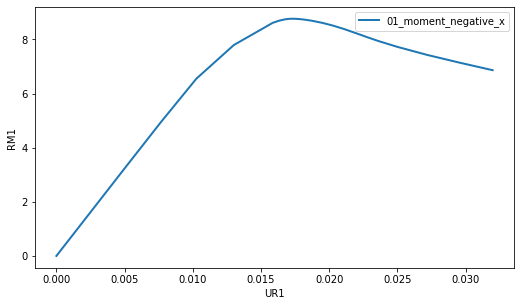

In [117]:
plot_curves(SP100_3W_CB, job_names, [0])

# SUPA80

## SP80-3W-CB

In [15]:
path = "d:/OneDrive/WorkFile/FEM/SP80/SP80-3W-CB/Results/5mm/"
job_names = get_jobnames(path)
SP80_3W_CB = get_df(job_names, path)

In [16]:
SP80_3W_CB_df = df_table('SP80_3W_CB', 'job_names', [0,1,2])
SP80_3W_CB_df

stiffness          k2  yield_load  \
specimen   load_type                                                  
SP80_3W_CB 02_moment_negative_x  249.671180  209.798693    4.265788   
           04_moment_negative_y  360.713517  320.998959    5.901466   
           06_shear_y             34.465934   18.070489   48.498148   

                                 ultimate_load  
specimen   load_type                            
SP80_3W_CB 02_moment_negative_x       4.594620  
           04_moment_negative_y       6.068280  
           06_shear_y                59.870539

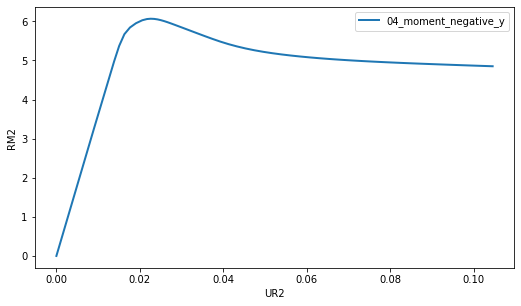

In [17]:
plot_curves(SP80_3W_CB, job_names, [1])

In [119]:
pd.concat([SP100_3W_CB_df, SP80_3W_CB_df])

stiffness          k2  yield_load  \
specimen    load_type                                                  
SP100_3W_CB 01_moment_negative_x  642.049694  577.844725    8.067387   
            02_moment_negative_y  969.448706  872.503836   11.779268   
            03_shear_y             62.534722   47.795288   77.000982   
SP80_3W_CB  02_moment_negative_x  249.671180  209.723791    4.266686   
            04_moment_negative_y  360.713517  320.674317    5.903327   
            06_shear_y             34.465934   18.060150   48.505817   

                                  ultimate_load  
specimen    load_type                            
SP100_3W_CB 01_moment_negative_x       8.764951  
            02_moment_negative_y      11.882813  
            03_shear_y                95.131258  
SP80_3W_CB  02_moment_negative_x       4.594620  
            04_moment_negative_y       6.068280  
            06_shear_y                59.870539

# Bolt

## SPBOLT-M12S

In [49]:
path = "d:/OneDrive/WorkFile/FEM/Bolts/Results/"
job_names = get_jobnames(path)
SPBOLT_M12S = get_df(job_names, path)

In [50]:
SPBOLT_M12S.describe()

,Model-5_round,Model-5_round.1,Model-5_round_18,Model-5_round_18.1,Model-5_round_18_no,Model-5_round_18_no.1
count,74.000000,74.000000,66.000000,66.000000,44.000000,44.000000
unique,74.000000,70.000000,66.000000,66.000000,44.000000,44.000000
top,0.875737,37.269848,0.873832,19.233865,1.516125,15.171866
freq,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000


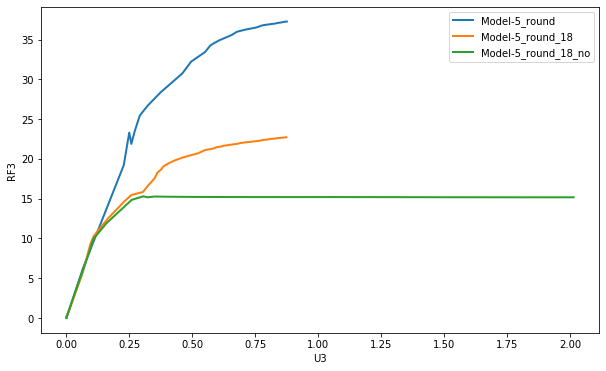

In [53]:
plot_curves(SPBOLT_M12S, job_names, [0,1,2])